In [1]:
from gnn_tracking.training.ec import ECModule

In [2]:
module = ECModule.load_from_checkpoint(
    "/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/legacy/lightning_logs/adorable-dalmatian-of-rain/checkpoints/epoch=19-step=144000.ckpt",
    map_location="cpu"
)

[03:15:36] DEBUG: Getting class EFMLP from module gnn_tracking.models.edge_filter
[03:15:36] DEBUG: Getting class HaughtyFocalLoss from module gnn_tracking.metrics.losses


In [3]:
from gnn_tracking.utils.loading import TrackingDataModule

dm = TrackingDataModule(
    train=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v5/part_1/"
        ],
    ),
    val=dict(
        dirs=[
            "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v5/part_9/"
        ],
        stop=5
    ),
)
dm.setup(stage="fit")

[12:28:09] INFO: DataLoader will load 28800 graphs (out of 28800 available).
[12:28:09] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v5/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v5/part_1/data21999_s9.pt
[12:28:09] INFO: DataLoader will load 5 graphs (out of 32000 available).
[12:28:09] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v5/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/graphs_v5/part_9/data29000_s12.pt


In [13]:
from gnn_tracking.analysis.edge_classification import collect_all_ec_stats
import numpy as np

df = collect_all_ec_stats(module, dm.val_dataloader(), np.linspace(0., 0.4, 40))

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [17]:
df

,threshold,acc,TPR,TNR,FPR,FNR,balanced_acc,F1,MCC,n_true,...,n_orphan_total_err,frac_segment100_err,frac_component100_err,frac_segment50_err,frac_component50_err,frac_segment75_err,frac_component75_err,n_segments_err,frac_hits_largest_segment_err,frac_hits_largest_component_err
0,0.000000,0.056872,1.000000,0.000000,1.000000,0.000000,0.500000,0.107564,0.000000,4808.0,...,0.0,0.007737,0.004101,0.000000,0.000000,0.010782,0.008673,0.008199,0.002817,0.002300
1,0.010256,0.524321,0.999876,0.495616,0.504384,0.000124,0.747746,0.192766,0.229682,4808.0,...,0.0,0.007737,0.004101,0.000000,0.000000,0.010782,0.008673,0.008199,0.002817,0.002300
2,0.020513,0.665832,0.999466,0.645670,0.354330,0.000534,0.822568,0.253466,0.305761,4808.0,...,0.0,0.007737,0.004101,0.000000,0.000000,0.010782,0.008673,0.008199,0.002817,0.002300
3,0.030769,0.750015,0.998904,0.734955,0.265045,0.001096,0.866930,0.311893,0.368022,4808.0,...,0.0,0.007737,0.004101,0.000000,0.000000,0.010782,0.008673,0.008199,0.002817,0.002300
4,0.041026,0.802893,0.997674,0.791103,0.208897,0.002326,0.894388,0.364721,0.419270,4808.0,...,0.0,0.007737,0.004101,0.000000,0.000000,0.010782,0.008673,0.008199,0.002817,0.002300
5,0.051282,0.838714,0.995951,0.829188,0.170812,0.004049,0.912570,0.411901,0.462537,4808.0,...,0.0,0.007737,0.004101,0.000000,0.000000,0.010782,0.008673,0.008199,0.002817,0.002300
6,0.061538,0.864747,0.994224,0.856897,0.143103,0.005776,0.925561,0.454637,0.500451,4808.0,...,0.0,0.007737,0.004101,0.000000,0.000000,0.010782,0.008673,0.008199,0.002817,0.002300
7,0.071795,0.883998,0.991647,0.877467,0.122533,0.008353,0.934557,0.492187,0.532904,4808.0,...,0.0,0.007737,0.005663,0.000000,0.000000,0.010782,0.009875,0.008199,0.002817,0.002427
8,0.082051,0.898870,0.988550,0.893423,0.106577,0.011450,0.940987,0.525626,0.561321,4808.0,...,0.0,0.007737,0.005663,0.000000,0.000000,0.010782,0.009875,0.008199,0.002817,0.002427
9,0.092308,0.911181,0.984232,0.906733,0.093267,0.015768,0.945482,0.556661,0.587260,4808.0,...,0.0,0.007737,0.005663,0.000000,0.000000,0.010782,0.009875,0.008199,0.002817,0.002427


In [19]:
[c for c in df.columns if c.startswith("n")]

['n_true',
 'n_false',
 'n_predicted_true',
 'n_predicted_false',
 'n_true_thld',
 'n_false_thld',
 'n_predicted_true_thld',
 'n_predicted_false_thld',
 'n_orphan_correct',
 'n_orphan_incorrect',
 'n_orphan_total',
 'n_segments',
 'n_true_err',
 'n_false_err',
 'n_predicted_true_err',
 'n_predicted_false_err',
 'n_true_thld_err',
 'n_false_thld_err',
 'n_predicted_true_thld_err',
 'n_predicted_false_thld_err',
 'n_orphan_correct_err',
 'n_orphan_incorrect_err',
 'n_orphan_total_err',
 'n_segments_err']

In [25]:
df["n"] = df["n_false"] + df["n_true"]
df["frac_predicted_false"] = df["n_predicted_false"] / df["n"]
# assuming 100% acc
df["approx_remaining_false"] = df["n_false"] - df["n_predicted_false"]
df["approx_remaining_frac_false"] = df["approx_remaining_false"] / df["n"]
df[["threshold", "frac_predicted_false", "approx_remaining_frac_false"]]


,threshold,frac_predicted_false,approx_remaining_frac_false
0,0.000000,0.000000,0.943556
1,0.010256,0.468120,0.475436
2,0.020513,0.609789,0.333767
3,0.030769,0.694115,0.249441
4,0.041026,0.747072,0.196484
5,0.051282,0.783052,0.160504
6,0.061538,0.809250,0.134306
7,0.071795,0.828740,0.114816
8,0.082051,0.843943,0.099613
9,0.092308,0.856720,0.086836


In [14]:
from gnn_tracking.analysis.edge_classification import ThresholdTrackInfoPlot

ttip = ThresholdTrackInfoPlot(df)

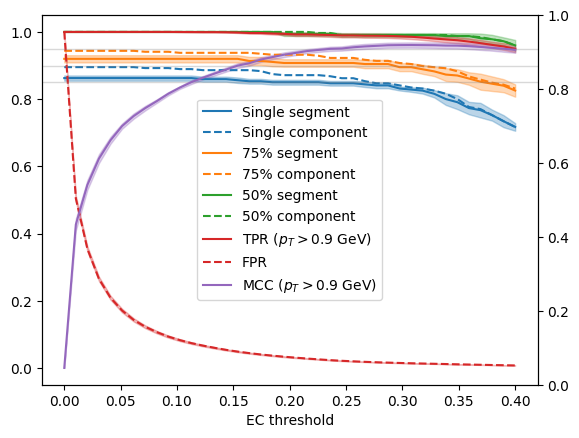

In [16]:
ttip.plot()
ax2 = ttip.ax.twinx()
# ax2.plot(df["threshold"], df["n_predicted_true"], color="red")

In [19]:
df["n_edges"] = df["n_true"] + df["n_false"]

In [22]:
ax2.get_figure().show()

In [42]:
import networkx as nx
from torch import Tensor as T


def get_cc_labels(edge_index: T, ) -> T:

    gx = nx.Graph()
    gx.add_nodes_from(list(range(data.num_nodes)))
    gx.add_edges_from(edge_index.T.detach().cpu().numpy())
    components = nx.connected_components(gx)
    index_mapping = {node: index for index,node_set in enumerate(components) for node in node_set}
    return T([index_mapping[node] for node in gx.nodes()])

data =dm.datasets["val"][0]

In [20]:
from gnn_tracking.metrics.cluster_metrics import tracking_metrics, TrackingMetrics
from torch_geometric.data import Data
from typing import Iterable


def tracking_metrics_data(data: Data, labels, pt_thlds: Iterable[float],
    predicted_count_thld=3,
    max_eta=4,) -> dict[float, TrackingMetrics]:
    return tracking_metrics(
        truth=data.particle_id.detach().cpu().numpy(),
        predicted=labels,
        pts=data.pt.detach().cpu().numpy(),
        reconstructable=data.reconstructable.detach().cpu().numpy(),
        eta=data.eta.detach().cpu().numpy(),
        pt_thlds=pt_thlds,
        max_eta=max_eta,
        predicted_count_thld=predicted_count_thld,
    )

In [23]:
module(data)["W"].shape

torch.Size([82566])

In [25]:
data.edge_index.shape

torch.Size([2, 82566])

In [43]:
dc = data.edge_subgraph(module(data)["W"] > 0.52)
labels = get_cc_labels(dc.edge_index)
tracking_metrics_data(
    dc, labels.detach().cpu().numpy(), [0.9]
)

{0.9: {'n_particles': 63,
  'n_cleaned_clusters': 41,
  'perfect': 0.2698412698412698,
  'double_majority': 0.5396825396825397,
  'lhc': 0.9024390243902439,
  'fake_perfect': 0.38095238095238093,
  'fake_double_majority': 0.1111111111111111,
  'fake_lhc': 0.0975609756097561}}